[12.910685729157743, 14.927559642706155, 16.053794101760424, 17.345452754259263, 18.191985409651547, 18.945016107482378, 19.74311470992319, 20.487553684357465, 20.850556478680616, 20.86113881646424, 20.86483310548802, 21.783107655740714, 21.791229573897294, 21.91843219162154, 22.45667505247113, 23.308513584743515, 23.340868761479964, 23.437007747234027, 24.093261998325445, 24.11211853671065, 24.143096469688924, 24.65506118840686, 24.762574208990056, 24.989665041576306, 25.78208557536357, 25.964282064114734, 26.032570932907785, 26.48883519784527, 27.339393829627937, 28.2583050603467, 29.118083811814664, 29.37086362727046, 29.591361878466486, 30.752162153250687, 31.631680260893113, 32.139007903664705, 33.29567481759992, 34.017107511624424, 34.33083896004993, 35.546763015864784, 35.61389324569186, 35.622115524699375, 35.98398921302039, 36.501753110512325, 36.74977134923806, 38.00133329809035, 40.27248814167093, 43.97559211317718, 51.6825822838066]


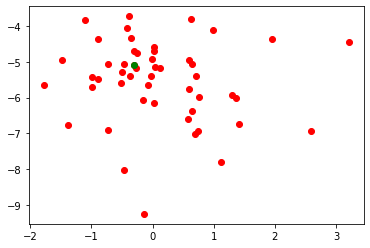

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
import random
import math
import matplotlib.pyplot as plt
from no_cluster import get_cluster
import copy

In [2]:
#random.seed(15)
P=2 #signal power threshold
#stream = BitStream()
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 30
        self.rounds = 200
        self.epochs = 2
        self.local_batches = 64
        self.lr = 0.01
        self.C = 0.9 #fraction of clients used in the round
        self.drop_rate = 0.1 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.csi_low=0
        self.csi_high=1
 
args = Arguments()

In [4]:
#checking if gpu is available
use_cuda = False
#print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
clients = []

#generating virtual clients
for i in range(int(args.clients)):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
    
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

In [5]:
for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average

#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 128)  #10 iid 50 non iid
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data,target=data,target
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get() 
    #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [8]:
def test(args, model, device, test_loader, name):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(100. * correct / len(test_loader.dataset))


In [9]:
torch.manual_seed(args.torch_seed)
#global_model = Net() #redundant code as we don't use it for training: assigns a CNN to the global model

for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    

accuracy=[]
rc=1

[11.871323996915047, 14.79902337027697, 15.328386679020964, 15.700433744483698, 16.086670403025476, 16.600019369449445, 16.7711187765215, 17.469609836230703, 17.661177361629704, 17.95348469852402, 18.01614173094554, 18.100861685934348, 18.26431005033572, 19.289800627641775, 19.800057250082794, 20.07301788455731, 20.132607923284134, 20.269435186230464, 20.325733409498863, 20.41701914003713, 20.439242681400653, 20.44343322334152, 21.272710011121728, 21.318021832463224, 21.454877241079096, 21.557033988571817, 21.622381021420004, 21.696661488261782, 22.370922305125944, 22.529058603044213, 22.61603763898114, 22.685118798953905, 22.94672918891382, 23.016015208921836, 23.02906018366594, 23.30727938910843, 24.107701940790335, 24.1727961505053, 24.319851277347205, 24.32039259831844, 24.766865791159326, 25.51300736763792, 25.723106623498857, 27.07341933295181, 27.08130181505439, 27.66322483757403, 28.53186626232639, 30.643876671747417, 31.20854189150696]


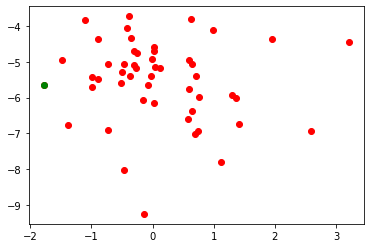

Power Allocated= 1.0841303456002018
CSI= 0.30764465799794105
SNR= 11.871323996915047
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1987990740484893
CSI= 0.4682010380718554
SNR= 14.79902337027697
Client: client2


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad


Model client2 Train Epoch: 1 [0/2048 (0%)]	Loss: 2.310719
Model client2 Train Epoch: 2 [0/2048 (0%)]	Loss: 2.335838

Power Allocated= 3.049499727411546
CSI= 0.77812897571924
SNR= 15.328386679020964
Client: client3
Model client3 Train Epoch: 1 [0/2048 (0%)]	Loss: 2.330751
Model client3 Train Epoch: 2 [0/2048 (0%)]	Loss: 1.283557

Power Allocated= 3.0740941409676292
CSI= 0.7933110660674946
SNR= 15.700433744483698
Client: client4
Model client4 Train Epoch: 1 [0/2048 (0%)]	Loss: 2.307906
Model client4 Train Epoch: 2 [0/2048 (0%)]	Loss: 1.437195

Power Allocated= 1.0296244828818173
CSI= 0.3025710148477049
SNR= 16.086670403025476
Client: client5
Model client5 Train Epoch: 1 [0/2048 (0%)]	Loss: 2.369959
Model client5 Train Epoch: 2 [0/2048 (0%)]	Loss: 0.518895

Power Allocated= 0
CSI= 0.021333975197576183
SNR= 16.600019369449445
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.8026974871332353
CSI= 0.2831308192139421
SNR= 16.7711187765215


/tmp/ipykernel_57227/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Client: client7
Model client7 Train Epoch: 1 [0/2048 (0%)]	Loss: 2.335184
Model client7 Train Epoch: 2 [0/2048 (0%)]	Loss: 1.247116

Power Allocated= 0
CSI= 0.11361309099416883
SNR= 17.469609836230703
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.024762919556218
CSI= 0.7634340707699888
SNR= 17.661177361629704
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.6137526869341996
CSI= 0.2687535533079487
SNR= 17.95348469852402
Client: client10
Model client10 Train Epoch: 1 [0/2048 (0%)]	Loss: 2.319986
Model client10 Train Epoch: 2 [0/2048 (0%)]	Loss: 1.871650

Power Allocated= 0
CSI= 0.023756800776675635
SNR= 18.01614173094554
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3684017174749243
CSI= 0.5085869810687379
SNR= 18.100861685934348
Client: client12
Model client12 Train Epoch: 1 [0/2048 (0%)]	Loss: 2.303244
Model client12 Train Epoch: 2 [0/2048 (0

IndexError: list index out of range

In [10]:
for fed_round in range(args.rounds):
    
    client_good_channel=[] #to check which clients have a good channel, only those will be taken for averaging per round

    # Training 
    #even slot
    
    snr=[] #snr of the channel
    csi=[] #csi of the channel
    for ii in range (int(args.clients)-1):
        #snr.append(random.uniform(args.snr_low, args.snr_high))
        csi.append(random.uniform(args.csi_low,args.csi_high))
    
    # if(fed_round==0):
    #     snr,cluster_head=get_cluster()
    if(fed_round==0): #fed_round==0 or True                                        %%%static or moving
        snr,cluster_head=get_cluster()
        temp=copy.deepcopy(cluster_head)
        temp1=copy.deepcopy(snr)
    else:
        #print(temp)
        cluster_head=copy.deepcopy(temp)
        snr=copy.deepcopy(temp1)
    #print(cluster_head)
    smallmu1=0
    gsmall1=3.402823466E+38 
    
    #water filling algorithm
    mu=1e-15
    while(mu<=1):
        #print("yay")
        #pn=max(1/mu-1/csi,0)
        g1=0
        pn1=0
        for jj in csi:
            pn=max(1/mu-1/jj,0)
            g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
            pn1+=pn
        g=g1-mu*(pn1-P*(int(args.clients)-1))
        if(g<gsmall1):
            smallmu1=mu
            gsmall1=g
        mu+=0.00002

    #print(smallmu1)
    # poptim=max(1/smallmu1-1/csi1,0)
    # print(poptim)
    index=0
    members=[]
    for i in clients:
        if(i['hook'].id!=cluster_head):
            members.append(i)
        else:
            head=i
    for client in members:
        goodchannel=ClientUpdate(args, device, client,key_np,key,snr[index],csi[index],smallmu1)
        if(goodchannel):
            client_good_channel.append(client)
        index+=1
        
    po=[]    
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    
    plt.bar([str(i) for i in range (1,len(po)+1)],po,)
    csi.sort()
    po=[]
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    fig,ax=plt.subplots()
    line1=ax.plot(csi,po,label="channel power allocated")
    line2=ax.plot(csi,[1/smallmu1]*len(csi),label="maximum power allocated")
    ax.set_title("csi vs power allocated")
    ax.set_xlabel("csi (channel gain to noise ratio)")
    ax.set_ylabel("power allocated")
    ax.legend()
    #plt.show()
    

#     # Testing 
#     for client in active_clients:
#         test(args, client['model'], device, client['testset'], client['hook'].id)
    
    
    
    print()
    print("Clients having a good channel and considered for training")
    for no in range (len(client_good_channel)):
        print(client_good_channel[no]['hook'].id)
        
        
        
    # Averaging 
        #odd slot

    head['model'] = averageModels(head['model'],client_good_channel)
    # Testing the average model
    #test(args, global_model, device, global_test_loader, 'Global')
    ac=test(args, head['model'], device, global_test_loader, 'Final')
    accuracy.append(ac)
    
    print("Power in training Round=",sum(po))
    #print("Power cap=",P*len(active_clients))
    
    #print("Total Power =",power_odd+power_even)
    print()
            
    # Share the global model with the clients
    index=0
    for client in members:
        client['model'].load_state_dict(head['model'].state_dict())
        #client=CLientReturn(client,snr[index],csi[index],smallmu1) #CHANGE:Commented
        index+=1
        #client['model']=torch.quantization.quantize_dynamic(client['model'],{torch.nn.Conv2d},dtype=torch.qint8)
        #print(client['model'].conv1.weight.data)
    fig1,ax1=plt.subplots()
    ax1.plot([i for i in range(len(accuracy))],accuracy)
    plt.show()
    print(rc)
    rc+=1

In [ ]:
print(accuracy)